<a href="https://colab.research.google.com/github/IKnigencev/Deep-Learning-example/blob/main/SegmentationConstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подготовка

Датасет стройки взят с платного курса по программированию. Использовалась модель [Pyramid Scene Parsing Network](https://hszhao.github.io/projects/pspnet/).


### Импорт библиотек

In [ ]:
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, Reshape, AveragePooling2D, Dropout
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam 

import matplotlib.pyplot as plt 

from tensorflow.keras.preprocessing import image 

from tensorflow.keras import utils

import numpy as np 

from sklearn.model_selection import train_test_split

import gdown

import os 

import random

import time

from PIL import Image 

import gc 

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака

gdown.download(url, None, quiet=False)

!unzip -q 'construction_256x192.zip' # распоковываем архив

### Глобальные переменные

In [ ]:
train_path_origin = '/content/train/original'
train_path_segment = '/content/train/segment'

val_path_origin = '/content/val/original'
val_path_segment = '/content/val/segment'

img_width = 192
img_height = 256 
target_size = (img_width, img_height, 3)

class_count = 7

mode_color = 'rgb'

BATCH_SIZE = 32
EPOCHS = 15

In [ ]:
FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200) 


class_labels = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

## Утилиты

In [ ]:
def rgb_to_labels(list_img, img_height, img_width, class_labels):
  # Перевод изображения в метки классов
  
  result = []

  for i in list_img:

    sample = np.array(i)
    y = np.zeros((img_width, img_height, 1), dtype='uint8')

    for n, cls in enumerate(class_labels):
      y[np.where(np.all(sample == class_labels[n], axis = -1))] = n 

    result.append(y)

  print(np.array(result).shape)
  return np.array(result)

In [ ]:
def labels_to_rgb(list_img):
  # Перевод результата нейросети из одноконального изобраджения в rgb

  result = []

  for img in list_img:
    y = np.zeros((192, 256, 3), dtype='uint8')

    for i, cl in enumerate(class_labels):
      y[np.where(np.all(img==i, axis=-1))] = class_labels[i]
    
    result.append(y)
  
  return np.array(result)

In [ ]:
def plot_random_img_in_two_array(first_list, second_list, count):
  # Визуализация случайных фотографий из двух массивов 

  fig, axs = plt.subplots(2, count, figsize=(15,7))

  if len(second_list[0][0][0]) == 1:
      second_list = labels_to_rgb(second_list)

  for i in range(count):
      index = np.random.randint(0, len(first_list))

      axs[0, i].axis('off')
      axs[0, i].imshow(first_list[index].astype(np.uint8))
      axs[1, i].axis('off')
      axs[1, i].imshow(second_list[index].astype(np.uint8))

    
  plt.show()

In [ ]:
def plot_random_img_in_array(list_img, count):
  # Визуализация случайных изображений из массива 

  fig, axs = plt.subplots(1, count, figsize=(25, 10)) 

  for i in range(count):
    index = np.random.randint(0, len(list_img))

    axs[i].axis('off')
    axs[i].imshow(list_img[index].astype(np.uint8))

  plt.show()

In [ ]:
def load_image(data_path, img_size, name):
  # Загрузка изображений 

  list_img = []

  for img in sorted(os.listdir(data_path)):
    list_img.append(image.img_to_array(image.load_img(data_path + '/' + img, 
                                                      target_size=img_size)))

  print(f'В {name}: {len(list_img)} фотографий')
  return list_img


In [ ]:
def sampling(list_img):
  # Функция формирования выборки

  result = []

  for img in list_img:
    x = image.img_to_array(img)
    result.append(x)

  result = np.array(result)
  print(result.shape)

  return result


### Модель

In [ ]:
def pyramid_block(input, frame, filter, kernel=(2,2), activation='relu'):
  # Блок энкодера пирамиды 

  x = MaxPooling2D(pool_size=frame)(input)
  x = Conv2D(filter, kernel, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)
  x = UpSampling2D(size=frame)(x)

  return x

In [ ]:
def build_pspnet(model, x_train, y_train7, x_val, y_val7, EPOCHS, BATCH_SIZE, learning_rate=1e-3):
  # Построение модели + вывод схемы модели + обучение модели + вывод результатов изображений 
  model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss='sparse_categorical_crossentropy', 
                metrics=['sparse_categorical_accuracy'])
  
  print(model.summary())
  print('\n' * 3)

  print('Схема модели')
  display(utils.plot_model(model, show_shapes=True, dpi=50))

  print('\n' * 3)

  history = model.fit(x_train, y_train7,
                    validation_data=(x_val, y_val7),
                    epochs = EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=1)
  
  show_history_epochs(history)

  return model

In [ ]:
def show_history_epochs(history):
  # Вывод графика обучение модели

  plt.plot(history.history['sparse_categorical_accuracy'], 
           label='Оценка точности на тренировочных данных')
  plt.plot(history.history['val_sparse_categorical_accuracy'], 
           label='Оцнека точности на валидационных данных')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Точность')
  plt.legend()
  plt.show()

  plt.plot(history.history['loss'], 
           label='Ошибка на тренировочных данных')
  plt.plot(history.history['val_loss'], 
           label='Ошибка на валидационных данных')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.show()

In [ ]:
def chekedResult(model, x, count=7):
  # Проверка результата и визуализация вывода 

  indexed = np.random.randint(0, len(x), count)

  y_pred = np.argmax(model.predict(x), axis=-1)
  pred = labels_to_rgb(y_pred[..., None])

  fig, axs = plt.subplots(3, count, figsize=(20, 15))

  for i in range(count):
    axs[0,0].set_title('Результат работы модели:')
    axs[0,i].imshow(pred[indexed[i]].astype(np.uint8)) # Отображаем на графике в первой линии
    axs[0,i].axis('off')
    axs[1,0].set_title('Оригинальное изображение')
    axs[1,i].imshow(x[indexed[i]].astype(np.uint8)) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[1,i].axis('off')
    axs[2,0].set_title('Оригинальное сегментированное')
    axs[2,i].imshow(Y_val[indexed[i]].astype(np.uint8)) # Отображаем на графике в третьей линии оригинальное изображение        
    axs[2,i].axis('off')
  plt.show()

## Обработка данных

In [ ]:
# Загрузка изображений 

X_train = load_image(train_path_origin, target_size, 'train')
Y_train = load_image(train_path_segment, target_size, 'train')

X_val = load_image(val_path_origin, target_size, 'val')
Y_val = load_image(val_path_segment, target_size, 'val')

В train: 1900 фотографий
В train: 1900 фотографий
В val: 100 фотографий
В val: 100 фотографий


In [ ]:
# Подготовка данных к обучению. Перевод в numpy массив

x_train = sampling(X_train)
x_val = sampling(X_val)

(1900, 192, 256, 3)
(100, 192, 256, 3)


In [ ]:
# Преобразование сегментированных изображений 

y_train = rgb_to_labels(Y_train, img_height, img_width, class_labels)
y_val = rgb_to_labels(Y_val, img_height, img_width, class_labels)

(1900, 192, 256, 1)
(100, 192, 256, 1)


In [ ]:
# Преобразование 16 классов к 7
NEW_CLASS = (
    (FLOOR),
    (CEILING),
    (WALL),
    (APERTURE, DOOR, WINDOW),
    (COLUMN, RAILINGS, LADDER),
    (INVENTORY),
    (LAMP, WIRE, BEAM, EXTERNAL, BATTERY, PEOPLE))

new_set_class = []

for set_class in NEW_CLASS:
  n_class = []

  for i in range(len(class_labels)):

    if class_labels[i] in set_class or class_labels[i] == set_class:
      n_class.append(i)
  new_set_class.append(n_class)

print('Список номеров базовых классов, сгруппированных в новые классы:')
print(new_set_class)  

Список номеров базовых классов, сгруппированных в новые классы:
[[0], [1], [2], [4, 5, 6], [3, 8, 11], [12], [7, 9, 10, 13, 14, 15]]


In [ ]:
# Изменение тренировочных и валидационных данных 
y_train7 = y_train.copy()
y_val7 = y_val.copy()

for base_cl, new_cl in enumerate(new_set_class):

  for base_cls in new_cl:
    y_train7[base_cls == y_train7] = base_cl
    y_val7[base_cls == y_val7] = base_cl

print(len(new_set_class))

7


### Проверка изображений 

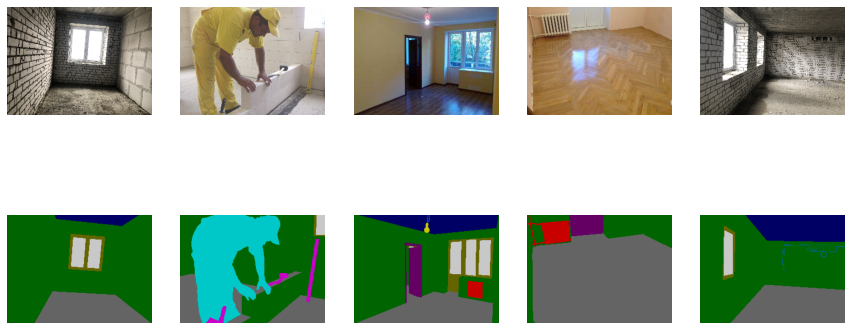

In [ ]:
plot_random_img_in_two_array(X_train, Y_train, 5)

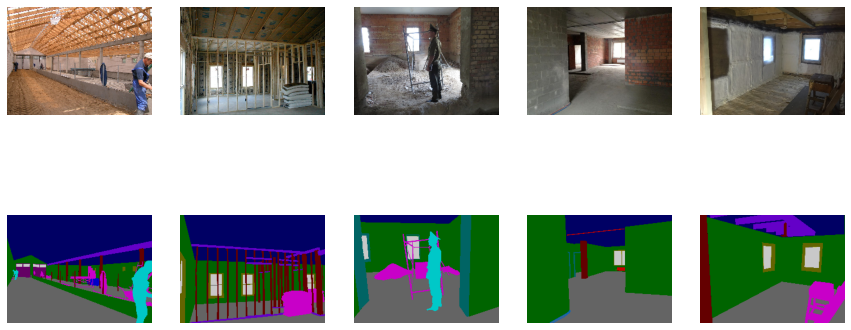

In [ ]:
plot_random_img_in_two_array(X_val, Y_val, 5)

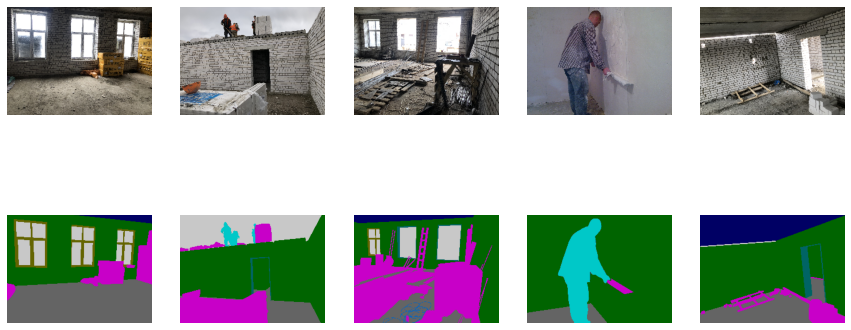

In [ ]:
plot_random_img_in_two_array(x_train, y_train, 5)

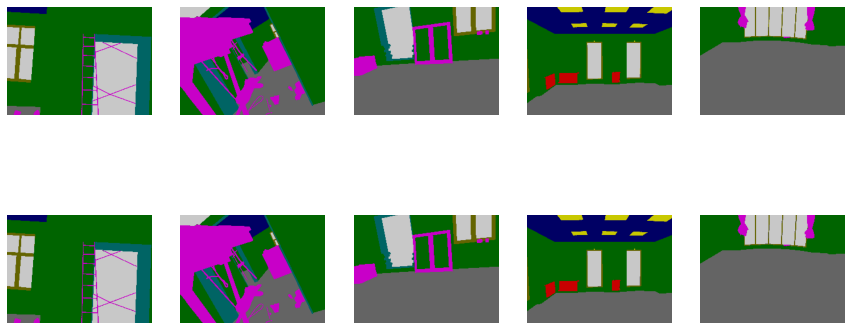

In [ ]:
plot_random_img_in_two_array(Y_train, y_train, 5)

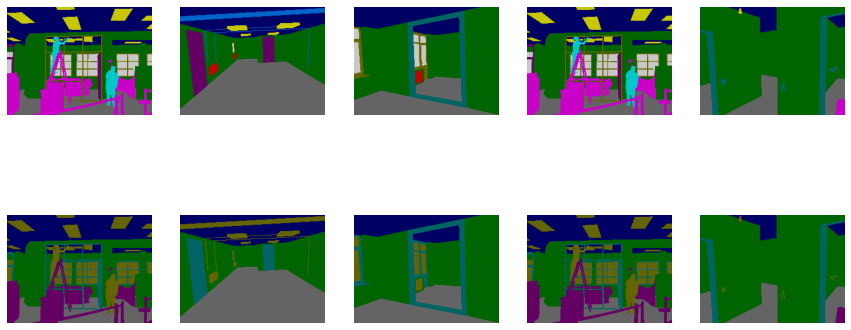

In [ ]:
plot_random_img_in_two_array(Y_val, y_val7, 5)

## Обучение модели

### Первый вариант 

In [ ]:
input_img = Input(target_size)

x = Conv2D(64, (3,3), padding='same')(input_img)
x = BatchNormalization()(x)
conv_in = Activation('relu')(x)

p_1 = pyramid_block(input_img,  1, 64)
p_2 = pyramid_block(input_img,  4, 64)
#p_3 = pyramid_block(input_img,  9, 64)
p_4 = pyramid_block(input_img,  16, 64)

x = concatenate([p_1, p_2, p_4])
x = Conv2D(64, (3,3), padding='same')(x)
x = BatchNormalization()(x)
conv_main = Activation('relu')(x)

conc = concatenate([conv_main, conv_in])
x = Conv2D(64, (3,3), padding='same')(conc)                            
x = BatchNormalization()(x)                                              
x = Activation('relu')(x)   

output = Conv2D(7, (3,3), padding='same', activation='softmax')(x)

model = Model(input_img, output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 192, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 48, 64, 3)   0           ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 16, 3)   0           ['input_1[0][0]']            

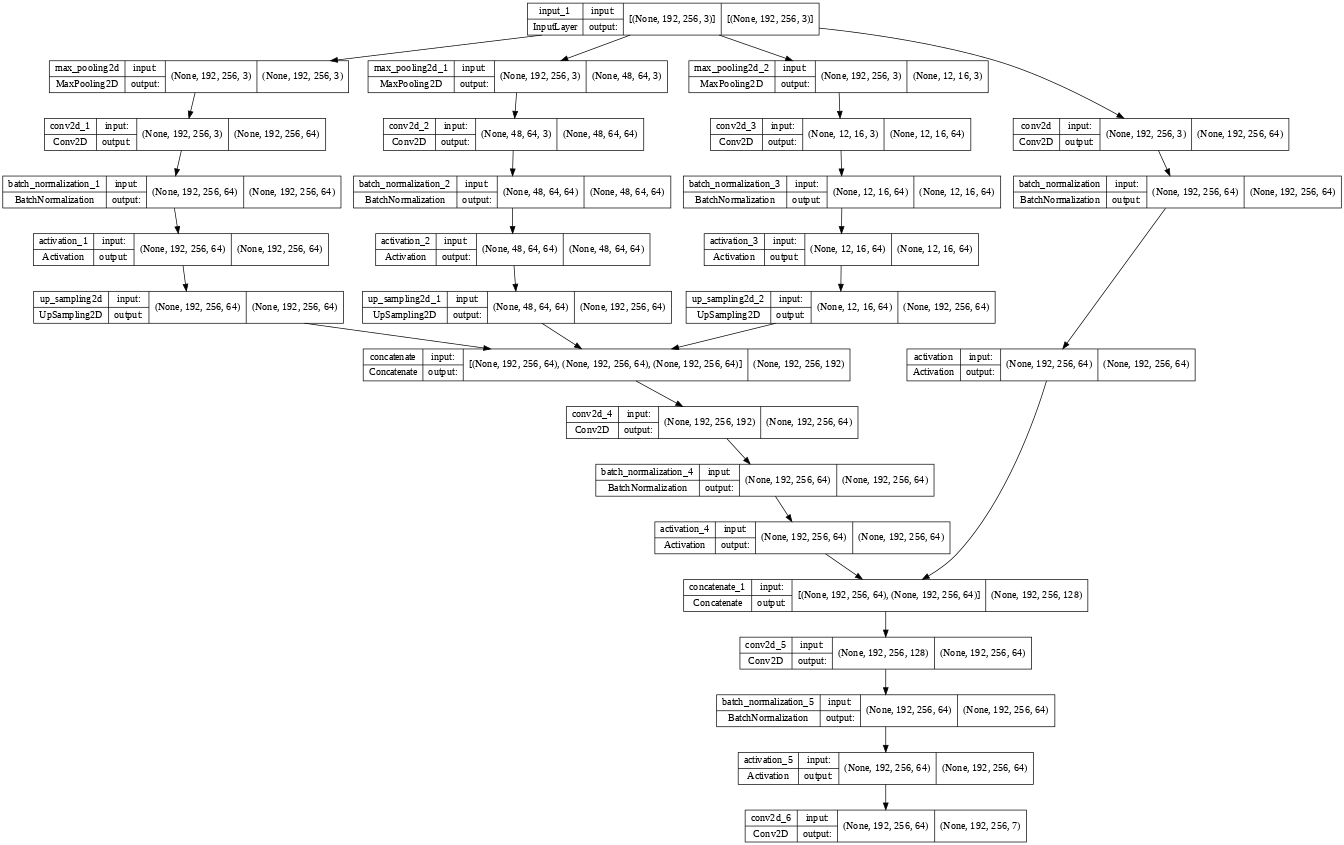





Epoch 1/15
60/60 [==============================] - 55s 626ms/step - loss: 1.2747 - sparse_categorical_accuracy: 0.5452 - val_loss: 4.8939 - val_sparse_categorical_accuracy: 0.1475
Epoch 2/15
60/60 [==============================] - 35s 585ms/step - loss: 1.1381 - sparse_categorical_accuracy: 0.5891 - val_loss: 2.2199 - val_sparse_categorical_accuracy: 0.2858
Epoch 3/15
60/60 [==============================] - 36s 602ms/step - loss: 1.0947 - sparse_categorical_accuracy: 0.6044 - val_loss: 1.5555 - val_sparse_categorical_accuracy: 0.4457
Epoch 4/15
60/60 [==============================] - 35s 588ms/step - loss: 1.0669 - sparse_categorical_accuracy: 0.6144 - val_loss: 1.4918 - val_sparse_categorical_accuracy: 0.4912
Epoch 5/15
60/60 [==============================] - 36s 595ms/step - loss: 1.0515 - sparse_categorical_accuracy: 0.6222 - val_loss: 1.3994 - val_sparse_categorical_accuracy: 0.5117
Epoch 6/15
60/60 [==============================] - 36s 594ms/step - loss: 1.0355 - sparse_

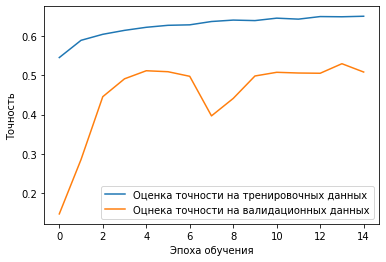

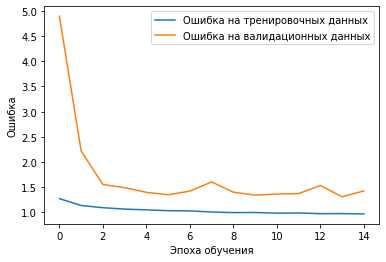

In [ ]:
pspnet = build_pspnet(model, x_train, y_train7, x_val, y_val7, EPOCHS, BATCH_SIZE, 1e-3)

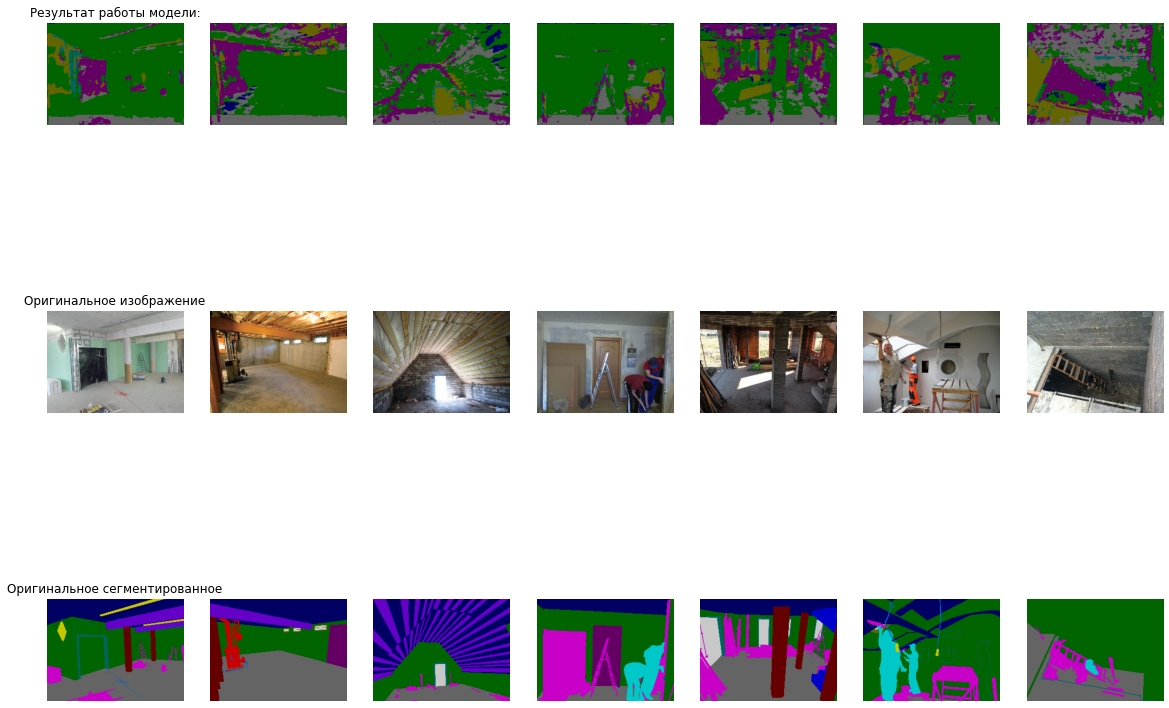

In [ ]:
chekedResult(pspnet, x_val)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 192, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 48, 64, 3)   0           ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 16, 3)   0           ['input_1[0][0]']            

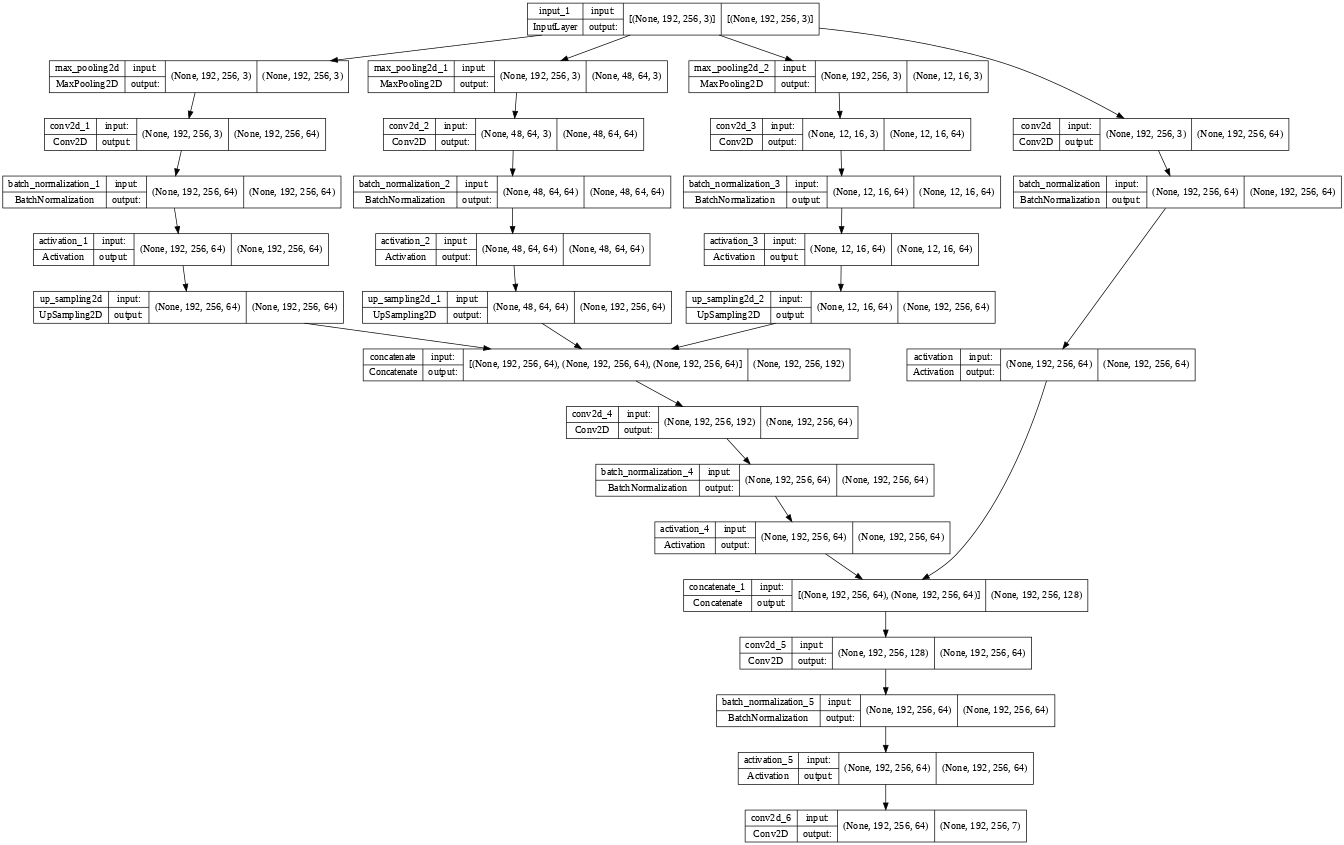





Epoch 1/15
60/60 [==============================] - 37s 600ms/step - loss: 0.9494 - sparse_categorical_accuracy: 0.6588 - val_loss: 1.3232 - val_sparse_categorical_accuracy: 0.5209
Epoch 2/15
60/60 [==============================] - 36s 596ms/step - loss: 0.9393 - sparse_categorical_accuracy: 0.6626 - val_loss: 1.2966 - val_sparse_categorical_accuracy: 0.5271
Epoch 3/15
60/60 [==============================] - 36s 594ms/step - loss: 0.9355 - sparse_categorical_accuracy: 0.6645 - val_loss: 1.2851 - val_sparse_categorical_accuracy: 0.5290
Epoch 4/15
60/60 [==============================] - 36s 595ms/step - loss: 0.9321 - sparse_categorical_accuracy: 0.6654 - val_loss: 1.2783 - val_sparse_categorical_accuracy: 0.5307
Epoch 5/15
60/60 [==============================] - 36s 595ms/step - loss: 0.9311 - sparse_categorical_accuracy: 0.6658 - val_loss: 1.2751 - val_sparse_categorical_accuracy: 0.5315
Epoch 6/15
60/60 [==============================] - 36s 595ms/step - loss: 0.9286 - sparse_

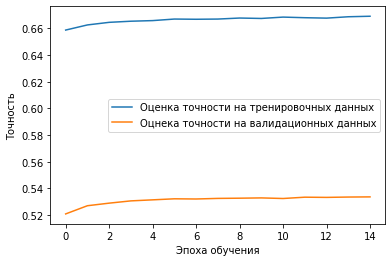

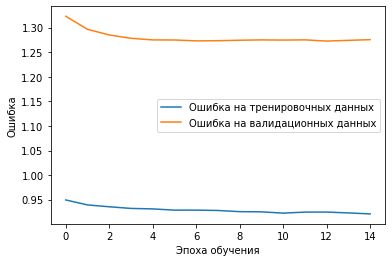

In [ ]:
pspnet_1 = build_pspnet(model, x_train, y_train7, x_val, y_val7, EPOCHS, BATCH_SIZE, 1e-5)

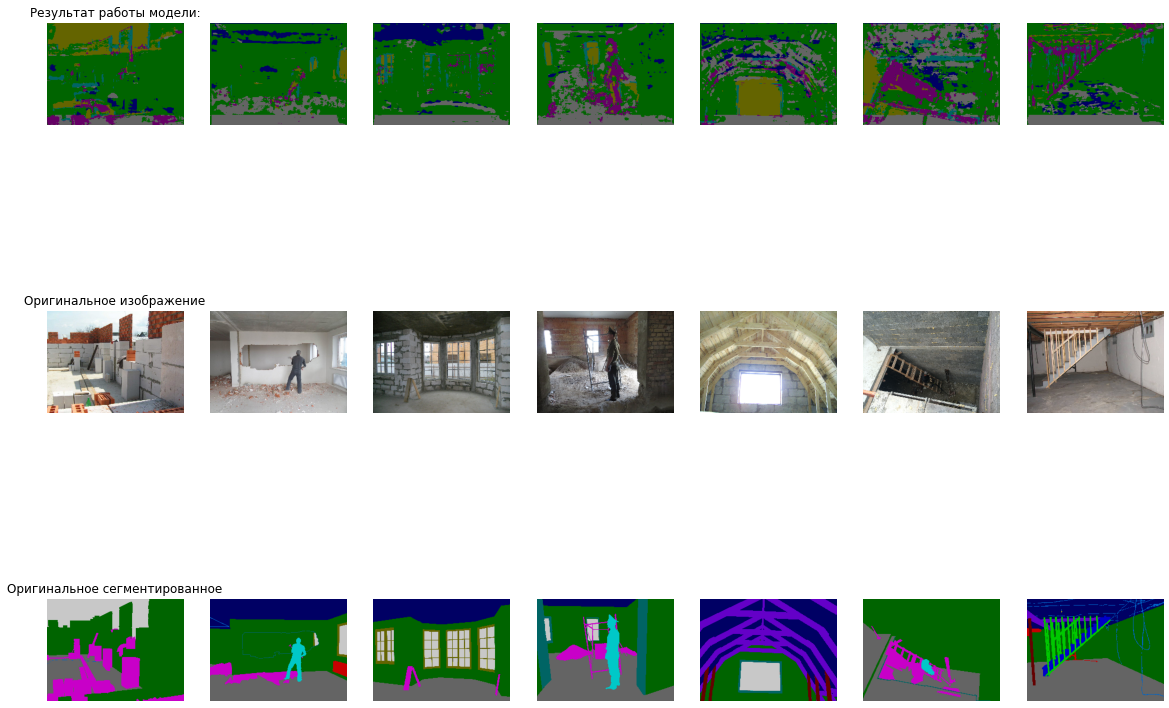

In [ ]:
chekedResult(pspnet_1, x_val)

### Второй вариант

In [ ]:
input_img = Input(target_size)

x = Conv2D(64, (3,3), padding='same')(input_img)
x = BatchNormalization()(x)
conc_in = Activation('relu')(x)

p_1 = pyramid_block(input_img, 2, 128)
p_2 = pyramid_block(input_img, 4, 128)
p_3 = pyramid_block(input_img, 16, 128)
p_4 = pyramid_block(input_img, 16, 128)


x = concatenate([p_1, p_2, p_3])
x = Conv2D(64, (3,3), padding='same')(x)
x = BatchNormalization()(x)
conc_main = Activation('relu')(x)

x = concatenate([conc_main, conc_in])
x = Conv2D(64, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(7, (3,3), padding='same', activation='softmax')(x)

model = Model(input_img, x)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 max_pooling2d_39 (MaxPooling2D  (None, 96, 128, 3)  0           ['input_11[0][0]']               
 )                                                                                                
                                                                                                  
 max_pooling2d_40 (MaxPooling2D  (None, 48, 64, 3)   0           ['input_11[0][0]']               
 )                                                                                          

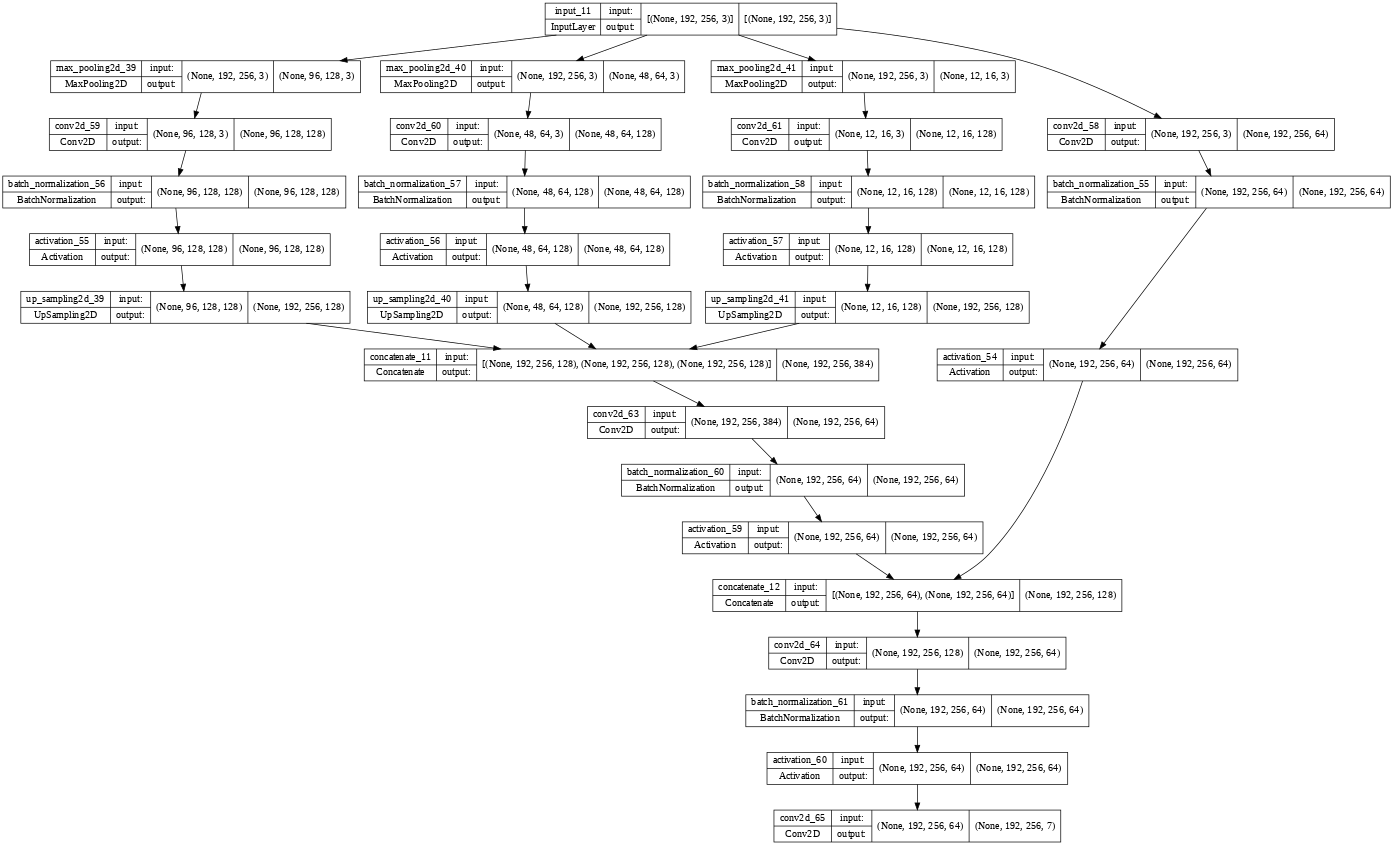





Epoch 1/15
60/60 [==============================] - 88s 1s/step - loss: 2.1575 - sparse_categorical_accuracy: 0.1793 - val_loss: 2.7095 - val_sparse_categorical_accuracy: 0.1605
Epoch 2/15
60/60 [==============================] - 71s 1s/step - loss: 1.8357 - sparse_categorical_accuracy: 0.2864 - val_loss: 2.1779 - val_sparse_categorical_accuracy: 0.1831
Epoch 3/15
60/60 [==============================] - 70s 1s/step - loss: 1.6790 - sparse_categorical_accuracy: 0.4021 - val_loss: 1.8711 - val_sparse_categorical_accuracy: 0.3017
Epoch 4/15
60/60 [==============================] - 70s 1s/step - loss: 1.5743 - sparse_categorical_accuracy: 0.4693 - val_loss: 1.7245 - val_sparse_categorical_accuracy: 0.3810
Epoch 5/15
60/60 [==============================] - 70s 1s/step - loss: 1.4980 - sparse_categorical_accuracy: 0.5066 - val_loss: 1.6273 - val_sparse_categorical_accuracy: 0.4299
Epoch 6/15
60/60 [==============================] - 70s 1s/step - loss: 1.4393 - sparse_categorical_accura

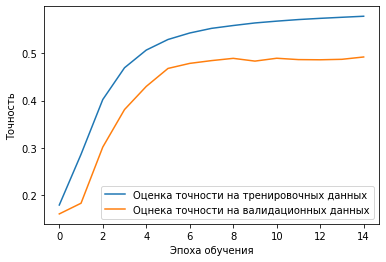

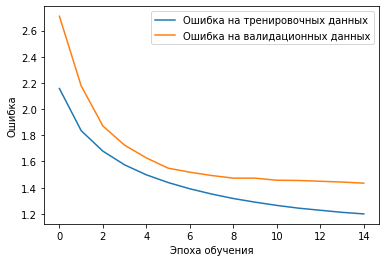

In [ ]:
pspnet_2 = build_pspnet(model, x_train, y_train7, x_val, y_val7, EPOCHS, BATCH_SIZE, learning_rate=1e-5)

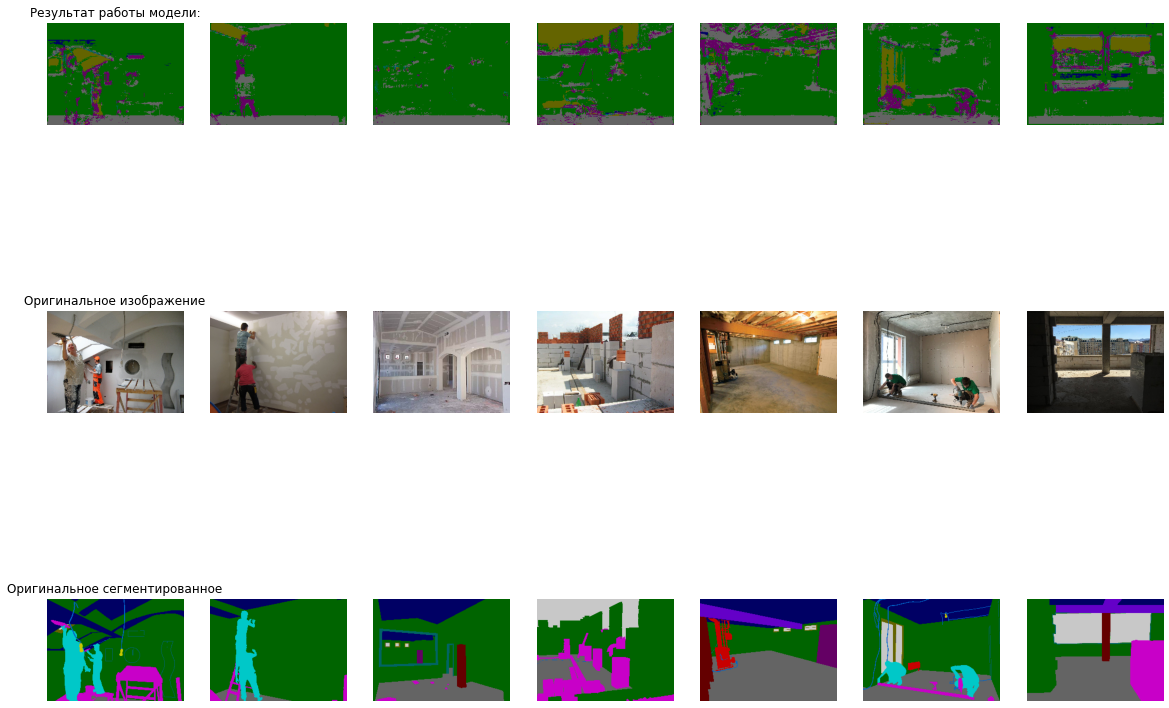

In [ ]:
chekedResult(pspnet_2, x_val)

### Третьий вариант 

In [ ]:
input_img = Input(target_size)

x = Conv2D(64, (3,3), padding='same')(input_img)
x = BatchNormalization()(x)
conc_in = Activation('relu')(x)

p_1 = pyramid_block(input_img, 32, 128)
p_2 = pyramid_block(input_img, 16, 128)
p_3 = pyramid_block(input_img, 16, 128)
p_4 = pyramid_block(input_img, 32, 64)
p_5 = pyramid_block(input_img, 2, 64)
p_6 = pyramid_block(input_img, 4, 64)
p_7 = pyramid_block(input_img, 16, 64)
p_8 = pyramid_block(input_img, 32, 128)


x = concatenate([p_1, p_2, p_3, p_4, p_5])
x = Conv2D(64, (3,3), padding='same')(x)
x = BatchNormalization()(x)
conc_main = Activation('relu')(x)

x = concatenate([conc_main, conc_in])
x = Conv2D(64, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(7, (3,3), padding='same', activation='softmax')(x)

model = Model(input_img, x)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 96, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 48, 64, 3)   0           ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 12, 16, 3)   0           ['input_2[0][0]']          

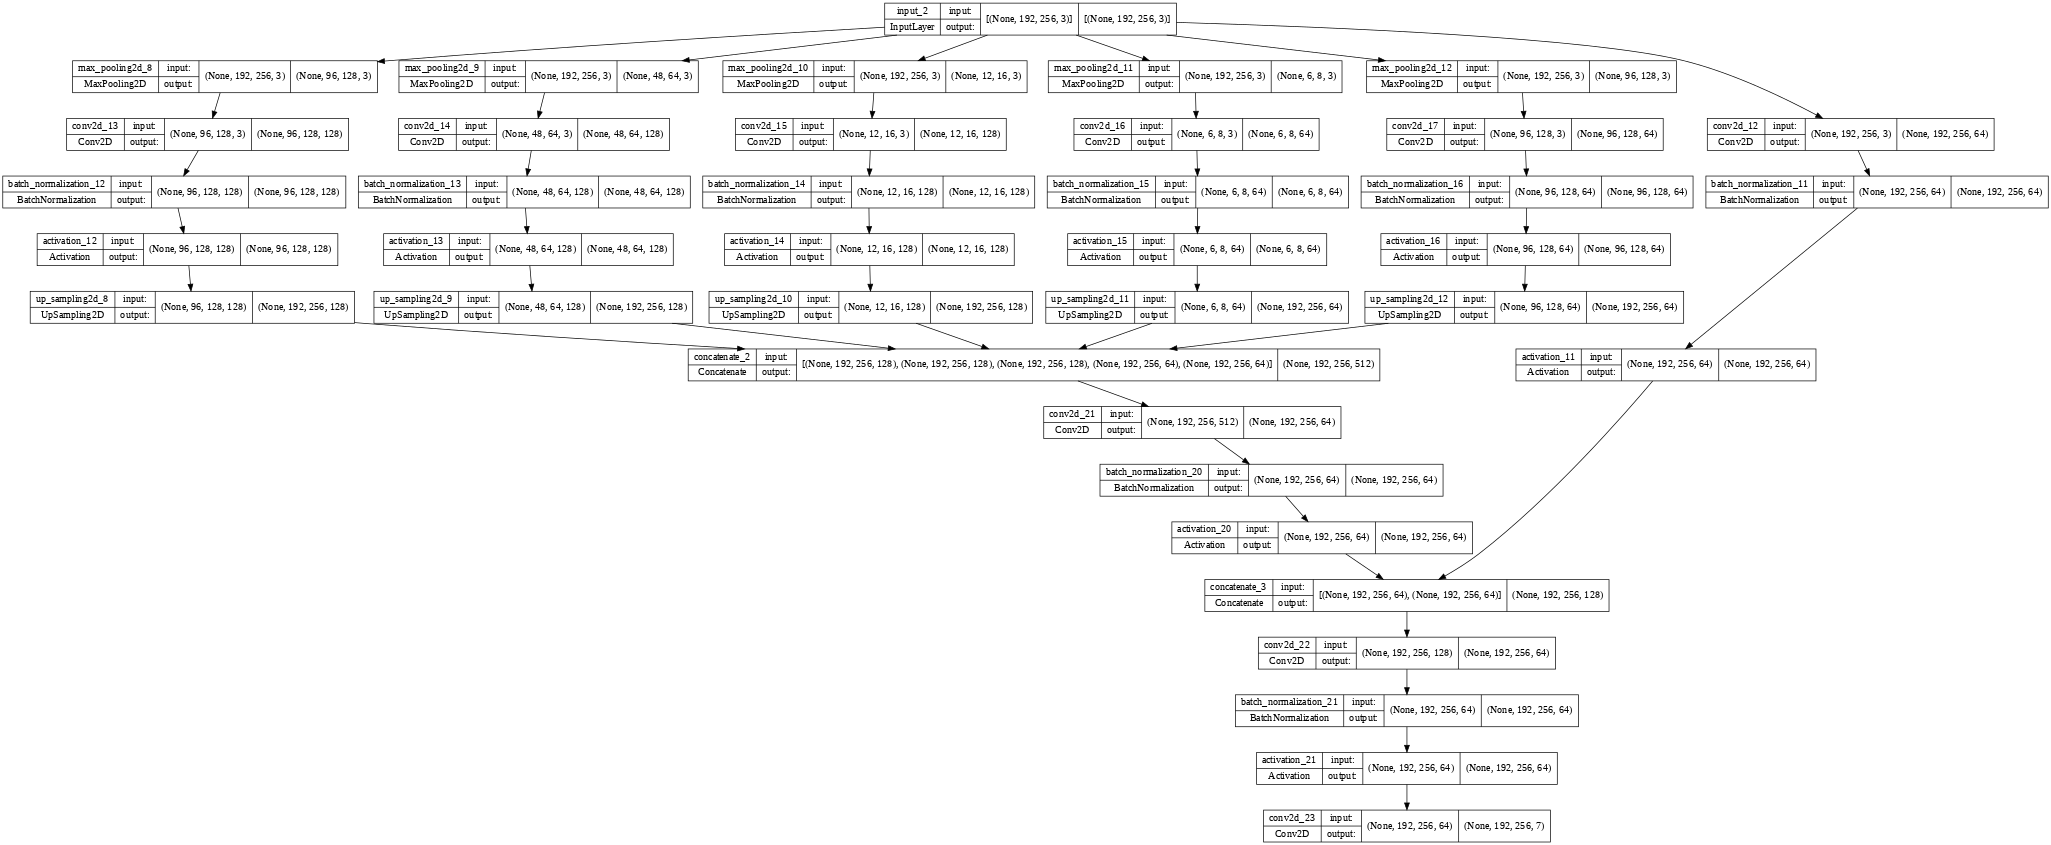





Epoch 1/15
60/60 [==============================] - 114s 2s/step - loss: 1.8788 - sparse_categorical_accuracy: 0.2425 - val_loss: 2.5799 - val_sparse_categorical_accuracy: 0.1222
Epoch 2/15
60/60 [==============================] - 91s 2s/step - loss: 1.5982 - sparse_categorical_accuracy: 0.4070 - val_loss: 2.0602 - val_sparse_categorical_accuracy: 0.2362
Epoch 3/15
60/60 [==============================] - 91s 2s/step - loss: 1.4701 - sparse_categorical_accuracy: 0.4959 - val_loss: 1.7050 - val_sparse_categorical_accuracy: 0.3853
Epoch 4/15
60/60 [==============================] - 91s 2s/step - loss: 1.3894 - sparse_categorical_accuracy: 0.5396 - val_loss: 1.5523 - val_sparse_categorical_accuracy: 0.4533
Epoch 5/15
60/60 [==============================] - 91s 2s/step - loss: 1.3317 - sparse_categorical_accuracy: 0.5601 - val_loss: 1.4828 - val_sparse_categorical_accuracy: 0.4826
Epoch 6/15
60/60 [==============================] - 91s 2s/step - loss: 1.2874 - sparse_categorical_accur

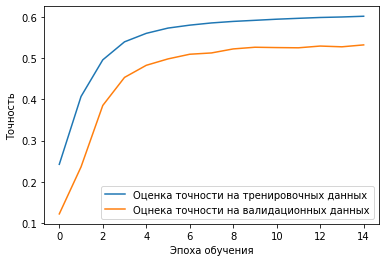

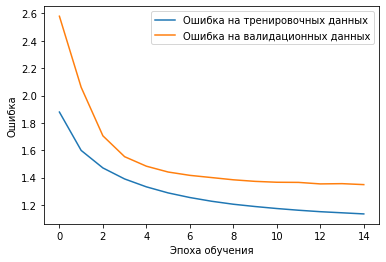

In [ ]:
pspnet_3 = build_pspnet(model, x_train, y_train7, x_val, y_val7, EPOCHS, BATCH_SIZE, learning_rate=1e-5)

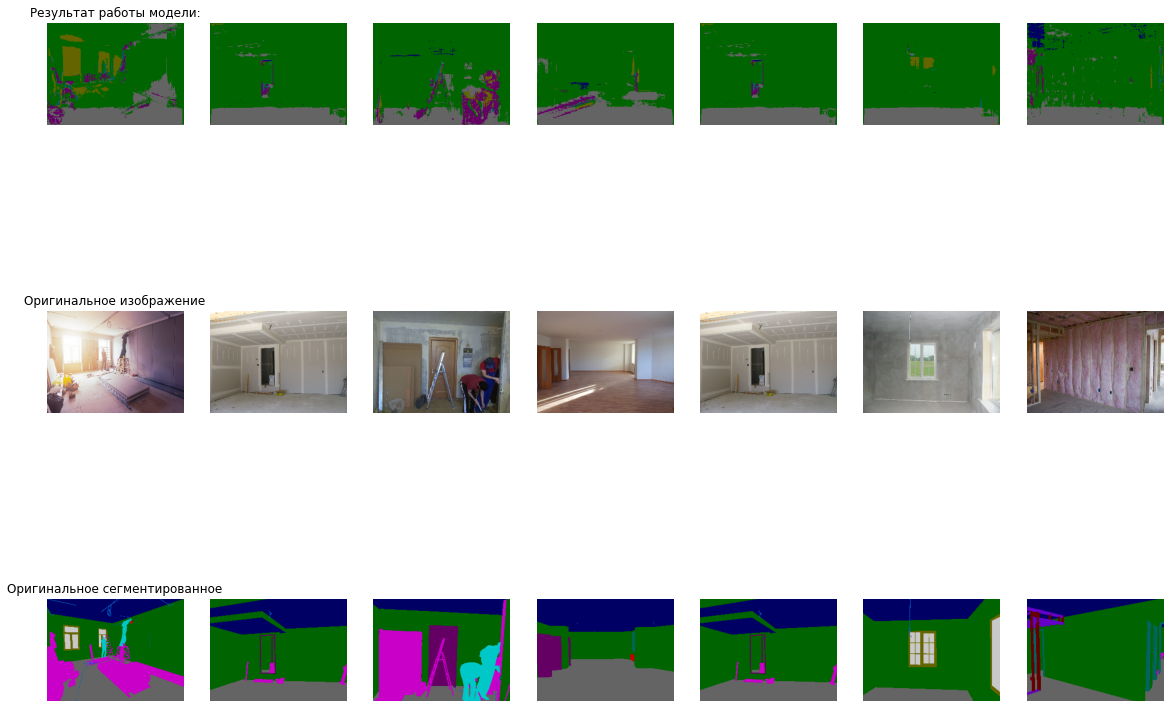

In [ ]:
chekedResult(pspnet_3, x_val)